# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [34]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

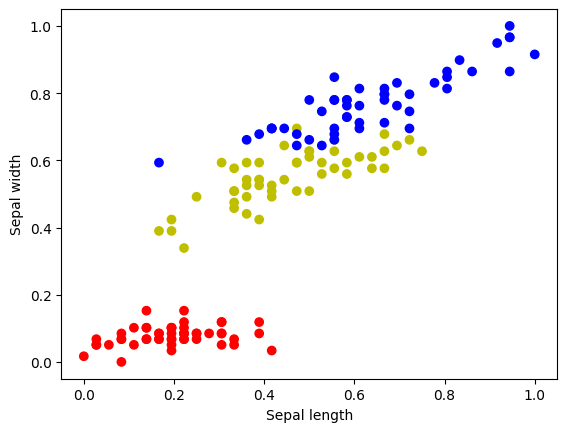

In [35]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [36]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [37]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [38]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [39]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.3112,  0.1014],
                      [ 0.4123,  0.5036],
                      [ 0.0815,  0.3790]])),
             ('bias', tensor([-0.1345,  0.4725,  0.6819]))])

### Fazendo um predict

In [40]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.1968,  0.5982,  0.7257],
        [-0.1795,  0.5753,  0.7211],
        [-0.1640,  0.5439,  0.7102],
        [-0.1519,  0.5495,  0.7208]], grad_fn=<AddmmBackward0>)

In [41]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.1745, 0.3865, 0.4390],
        [0.1789, 0.3807, 0.4404],
        [0.1843, 0.3740, 0.4417],
        [0.1849, 0.3728, 0.4424]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [42]:
F.softmax(out,dim=1)*100

tensor([[17.4517, 38.6478, 43.9005],
        [17.8937, 38.0653, 44.0410],
        [18.4283, 37.4022, 44.1696],
        [18.4850, 37.2756, 44.2393]], grad_fn=<MulBackward0>)

### Predição da classe

In [43]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4390, 0.4404, 0.4417, 0.4424], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [44]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [45]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.2069936990737915


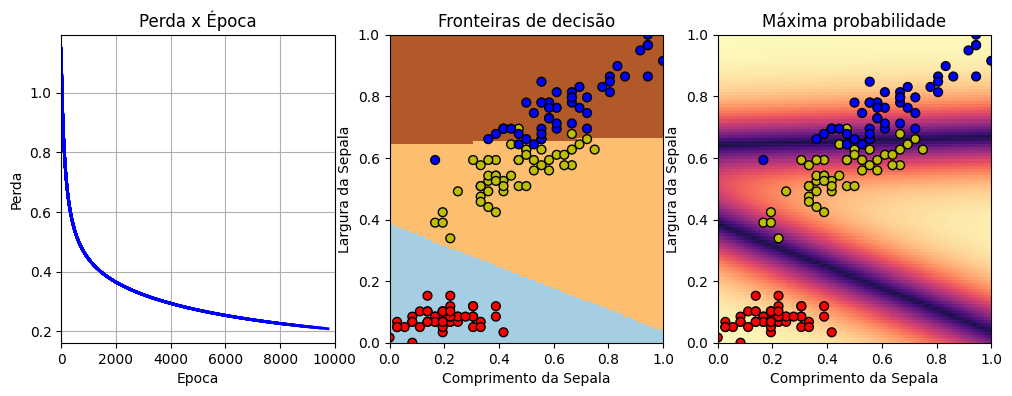

In [46]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [47]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.0079, -14.3692],
                      [  1.8472,  -0.3540],
                      [  1.3432,  15.7072]])),
             ('bias', tensor([ 7.3576,  1.9656, -8.3034]))])

### Salvando os parâmetros treinados

In [48]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [49]:
! ls ../models/

RegrLog_Iris.pt


In [50]:
nn.init.constant(model.weight,0)
model.state_dict()

/tmp/ipython-input-952960416.py:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.3576,  1.9656, -8.3034]))])

### Recuperando os pesos salvos

In [51]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.0079, -14.3692],
                      [  1.8472,  -0.3540],
                      [  1.3432,  15.7072]])),
             ('bias', tensor([ 7.3576,  1.9656, -8.3034]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [52]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [53]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?


Quando você executa novamente a célula de treinamento, os pesos continuam atualizados, porque o modelo continua existindo na memória do notebook. Então, a melhor coisa a se fazer é recriar o modelo:

```
model = torch.nn.Linear(4, 3)   # ou a classe usada no notebook
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```




2. Experimente refazer o treinamento com diferentes valores de learning rate

In [54]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

for lr in learning_rates:
    print("\nTreinando com learning rate =", lr)

    # recria o modelo CORRETO para 2 features
    model = nn.Linear(2, 3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(nb_epoch):
        optimizer.zero_grad()

        # forward
        out = model(X_tensor)

        # loss
        loss = criterion(out, Y_tensor)

        # backward
        loss.backward()

        # update
        optimizer.step()

    print("Loss final:", loss.item())



Treinando com learning rate = 0.001
Loss final: 0.8947405815124512

Treinando com learning rate = 0.01
Loss final: 0.4986596703529358

Treinando com learning rate = 0.1
Loss final: 0.24402481317520142

Treinando com learning rate = 0.5
Loss final: 0.12959179282188416

Treinando com learning rate = 1.0
Loss final: 0.10602722316980362


### Exercícios:

In [55]:
with torch.no_grad():
    logits = model(X_tensor)
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1)
    correct = (pred == Y_tensor)

# Organizar tudo em um dicionário
results = []
for i in range(len(X_tensor)):
    results.append({
        "index": i,
        "true": Y_tensor[i].item(),
        "pred": pred[i].item(),
        "prob_pred": probs[i][pred[i]].item(),
        "correct": correct[i].item()
    })

# Ordenar por probabilidade
results_sorted = sorted(results, key=lambda x: x["prob_pred"], reverse=True)


# 1. Observando o gráfico de máxima probabilidade, responda:
1. Qual é a amostra classificada corretamente, com maior probabilidade?

In [56]:
max_correct = max([r for r in results if r["correct"] == True],
                  key=lambda x: x["prob_pred"])
max_correct


{'index': 118,
 'true': 2,
 'pred': 2,
 'prob_pred': 0.999976396560669,
 'correct': True}

  2. Qual é a amostra classificada erradamente, com maior probabilidade?

In [57]:
max_wrong = max([r for r in results if r["correct"] == False],
                 key=lambda x: x["prob_pred"])
max_wrong


{'index': 83,
 'true': 1,
 'pred': 2,
 'prob_pred': 0.87298583984375,
 'correct': False}

3. Qual é a amostra classificada corretamente, com menor probabilidade

In [58]:
min_correct = min([r for r in results if r["correct"] == True],
                  key=lambda x: x["prob_pred"])
min_correct


{'index': 106,
 'true': 2,
 'pred': 2,
 'prob_pred': 0.5053118467330933,
 'correct': True}

 4. Qual é a amostra classificada erradamente, com menor probabilidade?

In [59]:
min_wrong = min([r for r in results if r["correct"] == False],
                key=lambda x: x["prob_pred"])
min_wrong


{'index': 72,
 'true': 1,
 'pred': 2,
 'prob_pred': 0.5094088315963745,
 'correct': False}


# 2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?


```
Linear(in_features=4, out_features=3, bias=True)
```
Os parâmetros são:

Pesos: 4 × 3 = 12

Bias: 3

Total: 15 parâmetros

# 3. Quantas entradas e quantas saídas esta rede possui?


Como está no notebook do Iris:

- 4 entradas (sepal length, sepal width, petal length, petal width)

- 3 saídas (setosa, versicolor, virginica)

# 4. Como se pode calcular a acurácia a partir da matriz de confusão?


|        | Pred 0 | Pred 1 | Pred 2 |
| ------ | ------ | ------ | ------ |
| True 0 | a      | b      | c      |
| True 1 | d      | e      | f      |
| True 2 | g      | h      | i      |

A acurácia é dada por:

\[
\text{Acurácia} = \frac{a + e + i}{a + b + c + d + e + f + g + h + i}
\]

Onde:
- \(a, e, i\) são os valores da diagonal principal da matriz de confusão
- \(a + b + c + d + e + f + g + h + i\) é o total de amostras



# 5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
- http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

```
values, indices = torch.max(tensor, dim=1)
```
Ela retorna 2 tensores:

values → o valor máximo ao longo do eixo fornecido

indices → o índice (posição) onde o máximo ocorreu
